In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import os
import pickle
import multiprocessing

In [76]:
import mixture_model
from xlms import XLMS_Dataset

In [17]:
## Plot the box plots of bootstrap results

In [18]:
# collect results

In [19]:
# list dir in

In [20]:
configs = ['no_constraint', 'unweighted_pdf_mode']
configs = ['unweighted_pdf_mode']

In [39]:
bootstrap_dir = '../bootstrap.old/'

In [21]:
%%sh
ls ../bootstrap/

check_all_bs.sh
check_all_ds.sh
diffsign_2S2_no_constraint_gaussian_initskew_1_2_5
diffsign_2S2_unweighted_pdf_mode_gaussian_initskew_1_2_5
index.pickle


## check all

In [22]:
import glob

In [23]:
def collect(d, depth):
    if depth == 0:
        return os.path.exists(f'{d}/models.pickle')
    print(d)
    # l = os.listdir(d)
    # keys = []
    res = []
    for dd in glob.glob(f'{d}/*'):
        if not os.path.isdir(dd):
            continue

        # keys.append(os.path.basename(dd))
        r = collect(dd, depth - 1)
        res.append(r)
    return res

In [25]:
res = collect(f'../{bootstrap_dir}/', 4)

../bootstrap.old/
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/0
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/1
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/10
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/11
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/12
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/13
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/14
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/15
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/16
../bootstrap.old/diffsign_1S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/ALott/17


In [13]:
# def count_grid(g):
#     if not isinstance(g[0], list):
#         return len(g)
#     return [count_grid(gg) for gg in g]
    

In [26]:
cnt = np.array(res).sum(-1)

In [27]:
cnt.shape

(3, 10, 50)

In [28]:
[[[(i, z) for i, z in enumerate(y) if z != 6] for y in x] for x in cnt]

[[[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []]]

In [29]:
res[0][6]

[[True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True, True, True],
 [True, True, True, True,

## Collect results

In [30]:
def addvar_prev_skeys(f):
    prev_skeys = []
    def _f(*args):
        return f(*args, prev_skeys)
    return _f

In [31]:
def all_same(x):
    x.count(x[0]) == len(x)


In [32]:
@addvar_prev_skeys
def load_dataset_res(dataset_name, basedir, prev_skeys = None):
    d = f'{basedir}/{dataset_name}'
    res = []
    keys = []
    
    # for bsi in os.listdir(d):
    #     # print(bsi)
    #     bsi = int(bsi)
    #     # if bsi in [0, 49]:
    #     #     continue
    #     # skeys, r = load_bootstrap_i(bsi, d)
    #     # if not prev_skeys:
    #     #     prev_skeys += skeys
    #     # # assert skeys == prev_skeys, (prev_skeys, skeys)
    #     # if skeys != prev_skeys:
    #     #     print(d, bsi)
    #     # keys.append(bsi)
    #     # res.append(r)

    with multiprocessing.Pool(50) as pool:
        all = pool.starmap(load_bootstrap_i, [(int(bsi), d) for bsi in os.listdir(d)])

    all_skeys, res = zip(*all)
    # if not all_same(all_skeys):
    #     print(pd.DataFrame(all_skeys))
        
    keys = [int(bsi) for bsi in os.listdir(d)]
    skeys = all_skeys[0]
    return [keys, *skeys], res

In [33]:
# @addvar_prev_skeys
def load_bootstrap_i(bsi, basedir, prev_skeys = None):
    d = f'{basedir}/{bsi}'
    res = []
    keys = []
    if prev_skeys is None:
        prev_skeys = []
    for skewinit in os.listdir(d):
        if not os.path.isdir(f'{d}/{skewinit}'):
            continue
        skeys, r = load_skewinit(skewinit, d)
        if not prev_skeys:
            prev_skeys += skeys
        # assert skeys == prev_skeys, (prev_skeys, skeys)
        if skeys != prev_skeys:
            print(d, skewinit)
        keys.append(skewinit)
        res.append(r)
    return [keys, *skeys], res

In [34]:
@addvar_prev_skeys
def load_skewinit(skewinit, basedir, prev_skeys = None):
    d = f'{basedir}/{skewinit}'
    # print(d)
    models = pickle.load(open(f'{d}/models.pickle', 'rb'))
    # print(len(models))
    assert(len(models) == 40)
    return [list(range(len(models)))], models

In [35]:
@addvar_prev_skeys
def load_config_res(config, nsample, basedir, prev_skeys = None):
    d = f'{basedir}/diffsign_{nsample}S2_{config}_gaussian_initskew_1_2_5'
    res = []
    keys = []
    for dataset in os.listdir(d):
        # if dataset == 'ALott':
        #     continue
        print(dataset)
        skeys, r = load_dataset_res(dataset, d)
        if not prev_skeys:
            prev_skeys += skeys
        # assert skeys == prev_skeys, (prev_skeys, skeys)
        if skeys != prev_skeys:
            print(d, dataset)
        keys.append(dataset)
        res.append(r)
    return [keys, *skeys], res

In [36]:
multiprocessing.active_children()

[]

In [42]:
def load_tda_bs_res():
    res = pickle.load(open(f'{bootstrap_dir}/TDA_thres.pickle', 'rb'))
    return res

In [43]:
tda_thres = load_tda_bs_res()

In [44]:
@addvar_prev_skeys
def load_bootstrap_res(basedir, prev_skeys = None):
    d = basedir
    res = []
    keys = []

    # for config, nsample in [('unweighted_pdf_mode', 1), ('no_constraint', 2), ('unweighted_pdf_mode', 2)]:
    for config, nsample in [('unweighted_pdf_mode', 1), ('unweighted_pdf_mode', 2)]:
    # for config, nsample in [('no_constraint', 2), ('unweighted_pdf_mode', 2)]:
        skeys, r = load_config_res(config, nsample, d)
        if not prev_skeys:
            prev_skeys += skeys
        # assert skeys == prev_skeys, (prev_skeys, skeys)
        if skeys != prev_skeys:
            print(d, config)
        keys.append(f'{config}_{nsample}S')
        res.append(r)
    
    return [keys, *skeys], res

skeys, r = load_bootstrap_res(bootstrap_dir)

ALott
Alinden
CPSF
D1810
MS2000225
QE
RPA
alban
ecoli_xl
peplib
ALott
Alinden
CPSF
D1810
MS2000225
QE
RPA
alban
ecoli_xl
peplib


In [29]:
pickle.dump((skeys, r), open('../bootstrap/res.pickle', 'wb'))

In [22]:
(skeys, r) = pickle.load(open('../bootstrap/res.pickle', 'rb'))

KeyboardInterrupt: 

In [47]:
res = np.array(r)

In [48]:
res.shape

(2, 10, 50, 6, 40)

In [49]:
list(map(lambda x:len(x[0]), r))

[50, 50]

In [50]:
skeys

[['unweighted_pdf_mode_1S', 'unweighted_pdf_mode_2S'],
 ['ALott',
  'Alinden',
  'CPSF',
  'D1810',
  'MS2000225',
  'QE',
  'RPA',
  'alban',
  'ecoli_xl',
  'peplib'],
 [0,
  1,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  2,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  3,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  4,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  5,
  6,
  7,
  8,
  9],
 ['random_1.0_-1.0_-1.0_-1.0_-1.0',
  'random_1.0_1.0_-1.0_-1.0_-1.0',
  'random_2.0_-2.0_-2.0_-2.0_-2.0',
  'random_2.0_2.0_-2.0_-2.0_-2.0',
  'random_5.0_-5.0_-5.0_-5.0_-5.0',
  'random_5.0_5.0_-5.0_-5.0_-5.0'],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39]]

In [51]:
def gen_ufunc(nin, nout):
    return lambda f: np.frompyfunc(f, nin, nout)

def reduce(f, arr, dims):
    r = arr
    for dim in dims:
        r = f.reduce(r, dim, keepdims=True)
    return r.squeeze(dims)



In [52]:
@gen_ufunc(2, 1)
def max_ll(x, y):
    if x['ll'] > y['ll']:
        return x
    else:
        return y

@gen_ufunc(1, 1)
def take_model(x):
    return x['model']

@gen_ufunc(1, 1)
def take_fdr_thres(x):
    return x.fdr_thres

In [53]:
bests = reduce(max_ll, res, (3, 4))
bests.shape

(2, 10, 50)

In [54]:
bests[0,0,0]['model'].fdr_thres

157.62825982550382

In [55]:
best_models = take_model(bests)
best_models.shape

(2, 10, 50)

In [56]:
skeys[0]

['unweighted_pdf_mode_1S', 'unweighted_pdf_mode_2S']

## Take thres

In [57]:
mix_thres = take_fdr_thres(take_model(bests[:, :, :])).astype(float)

## Cap thres to max score

In [58]:
mix_thres[:, 1, :]

array([[185.24489741, 177.22526397, 192.27742623, 195.84487639,
        188.47150913, 191.52372183, 188.47150913, 188.7389875 ,
        187.95923234, 191.22332642, 176.50967221, 189.62484657,
        174.79569678, 188.93927131, 177.93243001, 186.71256558,
        175.83610348, 185.07262488, 190.19627204, 189.72236191,
        175.93113981, 190.20079482, 189.46113967, 176.80324398,
        186.02713903, 175.93942476, 176.66993253, 185.40557655,
        191.67774615, 191.90324962, 189.35320892, 188.80176093,
        176.36104152, 188.95352575, 186.95003102, 186.09367285,
        176.76952349, 189.16804896, 178.01324411, 192.17810329,
        178.13828263, 188.72467876, 190.1815828 , 175.70392039,
        176.33882883, 176.70578899, 176.92766116, 177.74647238,
        189.210175  , 188.30865684],
       [225.42693338, 221.45274435, 224.02758137, 223.52846348,
        224.80291195, 227.62845416, 228.83973449, 227.17397842,
        226.7677202 , 234.41236871, 218.43875321, 228.55136475,
   

In [59]:
for j in range(best_models.shape[1]):
    dataset_name = skeys[1][j]
    print(dataset_name)
    model = best_models[0, j, 0]
    max_s = model.xrange[-1]

    ds_thres = mix_thres[:, j, :]
    ind = np.isinf(ds_thres)
    ds_thres[ind] = max_s


ALott
Alinden
CPSF
D1810
MS2000225
QE
RPA
alban
ecoli_xl
peplib


In [60]:
mix_thres[:, 1, :]

array([[185.24489741, 177.22526397, 192.27742623, 195.84487639,
        188.47150913, 191.52372183, 188.47150913, 188.7389875 ,
        187.95923234, 191.22332642, 176.50967221, 189.62484657,
        174.79569678, 188.93927131, 177.93243001, 186.71256558,
        175.83610348, 185.07262488, 190.19627204, 189.72236191,
        175.93113981, 190.20079482, 189.46113967, 176.80324398,
        186.02713903, 175.93942476, 176.66993253, 185.40557655,
        191.67774615, 191.90324962, 189.35320892, 188.80176093,
        176.36104152, 188.95352575, 186.95003102, 186.09367285,
        176.76952349, 189.16804896, 178.01324411, 192.17810329,
        178.13828263, 188.72467876, 190.1815828 , 175.70392039,
        176.33882883, 176.70578899, 176.92766116, 177.74647238,
        189.210175  , 188.30865684],
       [225.42693338, 221.45274435, 224.02758137, 223.52846348,
        224.80291195, 227.62845416, 228.83973449, 227.17397842,
        226.7677202 , 234.41236871, 218.43875321, 228.55136475,
   

## TDA Thres

In [61]:
tda_res = []
for dataset_name in skeys[1]:
    print(dataset_name)
    tda_res.append(tda_thres[dataset_name])
tda_res = np.array(tda_res)
tda_res

ALott
Alinden
CPSF
D1810
MS2000225
QE
RPA
alban
ecoli_xl
peplib


array([[185.04535194, 207.35340024, 213.72454084, 213.72454084,
        198.13478644, 207.35340024, 203.61751964, 213.72454084,
        203.61751964, 202.68847758, 196.94925363, 180.09904003,
        207.35340024, 185.04535194, 203.61751964, 211.33054839,
        180.48555658, 192.9214067 , 186.06620559, 207.35340024,
        211.33054839, 207.35340024, 195.6063259 , 207.35340024,
        167.51602132, 213.72454084, 203.61751964, 196.83417174,
        180.09904003, 202.67376678, 196.94925363, 202.68847758,
        207.35340024, 172.94990578, 172.59779103, 203.61751964,
        183.82350508, 192.84927197, 184.37900022, 211.33054839,
        196.83417174, 195.6063259 , 196.83417174, 202.68847758,
        196.83417174, 207.35340024, 211.33054839, 213.72454084,
        213.72454084, 211.33054839],
       [230.90747089, 232.97599111, 229.88451313, 232.24961253,
        229.30372762, 231.88579495, 227.51890511, 226.95763668,
        230.14370539, 231.97983392, 231.53369802, 227.9821733 ,
   

## Merge tda and mix

In [62]:
tda_res.shape

(10, 50)

In [63]:
mix_thres.shape

(2, 10, 50)

In [64]:
all_thres = np.vstack([np.expand_dims(tda_res, 0), mix_thres])
all_thres.shape

(3, 10, 50)

In [65]:
pickle.dump(all_thres, open(f'{bootstrap_dir}/all_thres.pickle', 'wb'))

In [49]:
pickle.dump(skeys, open(f'{bootstrap_dir}/skeys.pickle', 'wb'))

In [66]:
# all_thres = pickle.load(open('', 'rb'))

## Plot thres

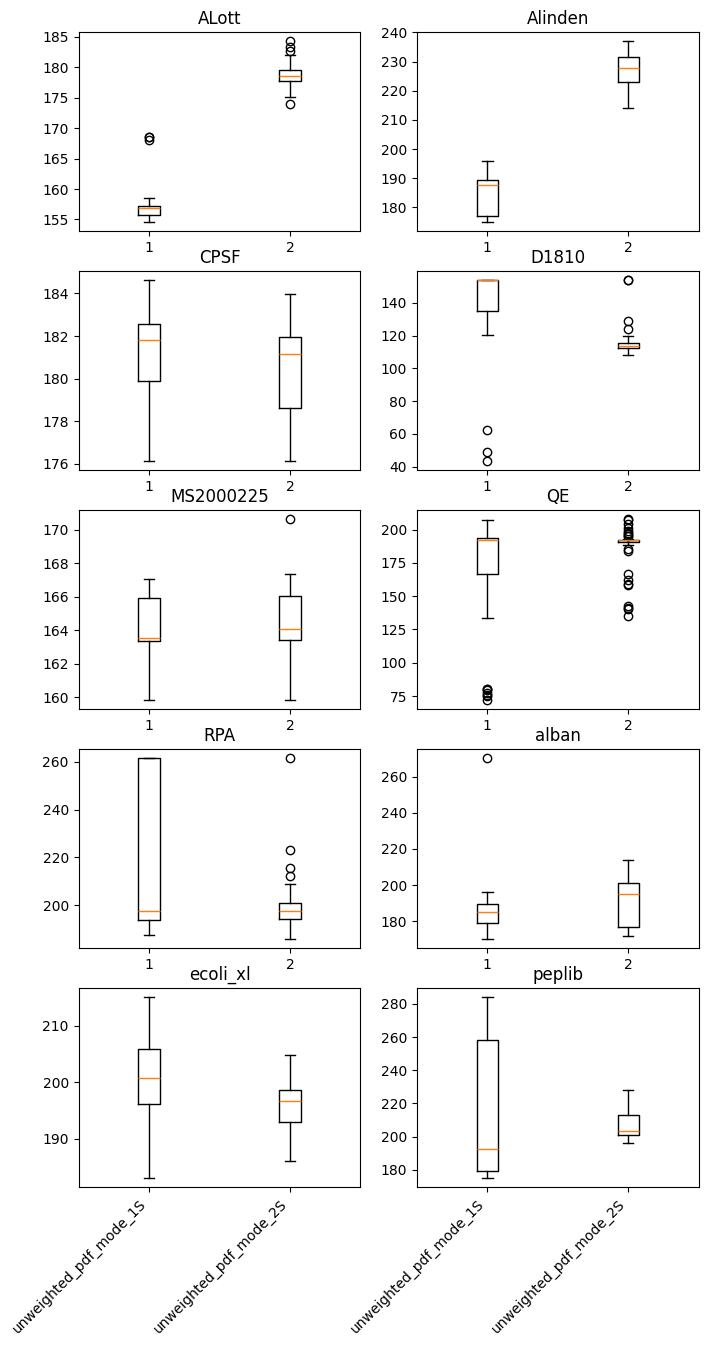

In [51]:
# for i in range(3):
fig = plt.figure(figsize=(8, 3 * 5))

for j in range(best_models.shape[1]):
    ax = plt.subplot(5, 2, j+1)
    # ax.boxplot(take_fdr_thres(take_model(bests[:, j, :].T)))
    # ax.boxplot(all_thres[:, j, :].T)
    ax.boxplot(mix_thres[:, j, :].T)
    ax.set_title(skeys[1][j])
    if j >= 8:
        ax.set_xticklabels(skeys[0], rotation=45, ha='right')
    # fig.align_labels()

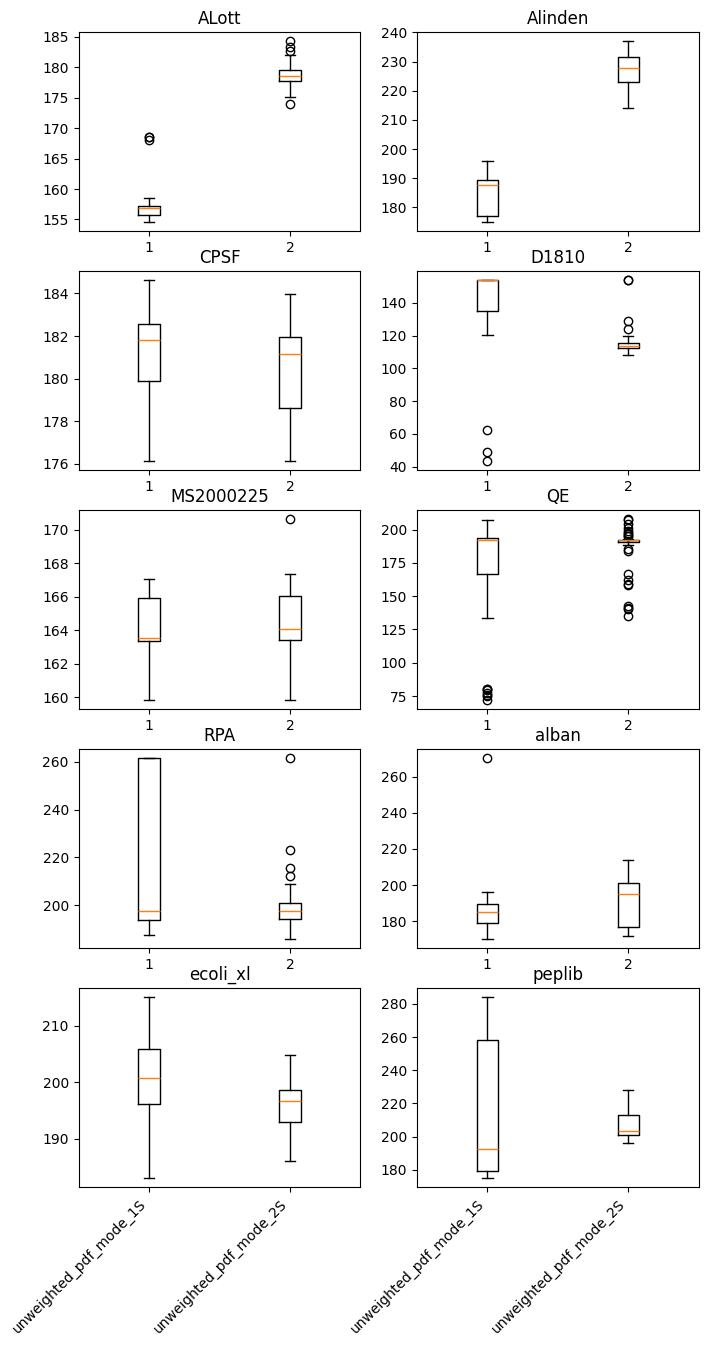

In [67]:
# for i in range(3):
fig = plt.figure(figsize=(8, 3 * 5))

for j in range(best_models.shape[1]):
    ax = plt.subplot(5, 2, j+1)
    # ax.boxplot(take_fdr_thres(take_model(bests[:, j, :].T)))
    # ax.boxplot(all_thres[:, j, :].T)
    ax.boxplot(mix_thres[:, j, :].T)
    ax.set_title(skeys[1][j])
    if j >= 8:
        ax.set_xticklabels(skeys[0], rotation=45, ha='right')
    # fig.align_labels()

In [68]:
def box_plot(ax, x, data, edge_color, fill_color):
    bp = ax.boxplot(data, positions=x, notch=False, showfliers=False, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
    
    return bp['boxes'][0]

In [93]:
import matplotlib
cmap = matplotlib.colormaps['tab10']

cmap([1, 2, 3])

array([[1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ]])

In [69]:
def capitalize(s):
    return s[0].upper() + s[1:]

In [70]:
def plot_threses(dataset_name, threses, ax, show_tick_label=False, show_legend=False, show_ylabel=False):
    # for i in range(threses.shape[1]):
        # ax.boxplot(threses, notch=False, showfliers=False, boxprops={'color': })
    arts = []
    for i in range(threses.shape[1]):
        # box_plot(ax, [i], threses[:, i], cmap(i), cmap(i))
        arts.append(box_plot(ax, [i], threses[:, i], cmap(i), 'white'))
    # ax.boxplot(mix_thres[:, j, :].T)
    ax.set_title(capitalize(dataset_name.replace('_xl', '')))
    print(threses.shape)
    ax.set_xticklabels([''] * threses.shape[1])
    if show_legend:
        ax.legend(arts, ['TDA', '1SMix', '2SMix'])
    # if show_tick_label:
    #     ax.set_xticklabels(['TDA'] + skeys[0], rotation=45, ha='right')
    # else:
    #     ax.set_xticklabels([''] * threses.shape[1])
    if show_ylabel:
        ax.set_ylabel('1% FDR Threshold')

In [56]:
plot_datasets = ['ALott', 'D1810', 'CPSF', 'ecoli_xl',]

4 1
(50, 3)
(50, 3)
(50, 3)
(50, 3)


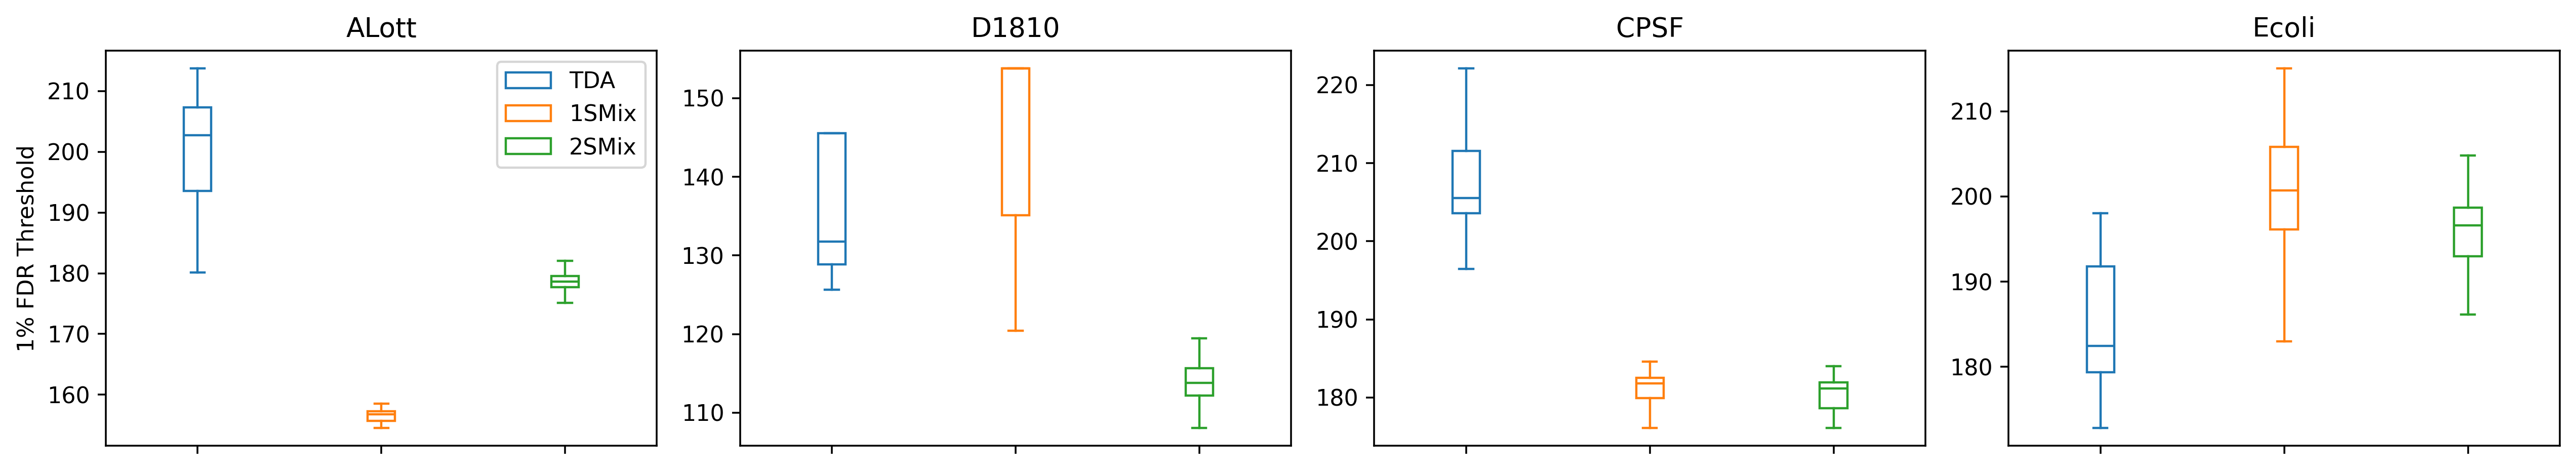

In [57]:
j = 0

dataset_ind = {dataset_name: i for i, dataset_name in enumerate(skeys[1])}

ncols = 4
nrows = (len(plot_datasets) + ncols - 1) // ncols

print(ncols, nrows)

fig = plt.figure(figsize=[4 * ncols, 3 * nrows], dpi=320)
for dataset_name in plot_datasets:
    ind = dataset_ind[dataset_name]
    ax = plt.subplot(nrows, ncols, j + 1)
    # plot_threses(dataset_name, all_thres[:, ind, :].T, ax, j >= len(plot_datasets) - 2)
    plot_threses(dataset_name, all_thres[:, ind, :].T, ax, show_legend=j==0, show_ylabel=j==0)
    j += 1

fig.tight_layout()

In [52]:
fig.savefig('../bootstrap_plot.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)


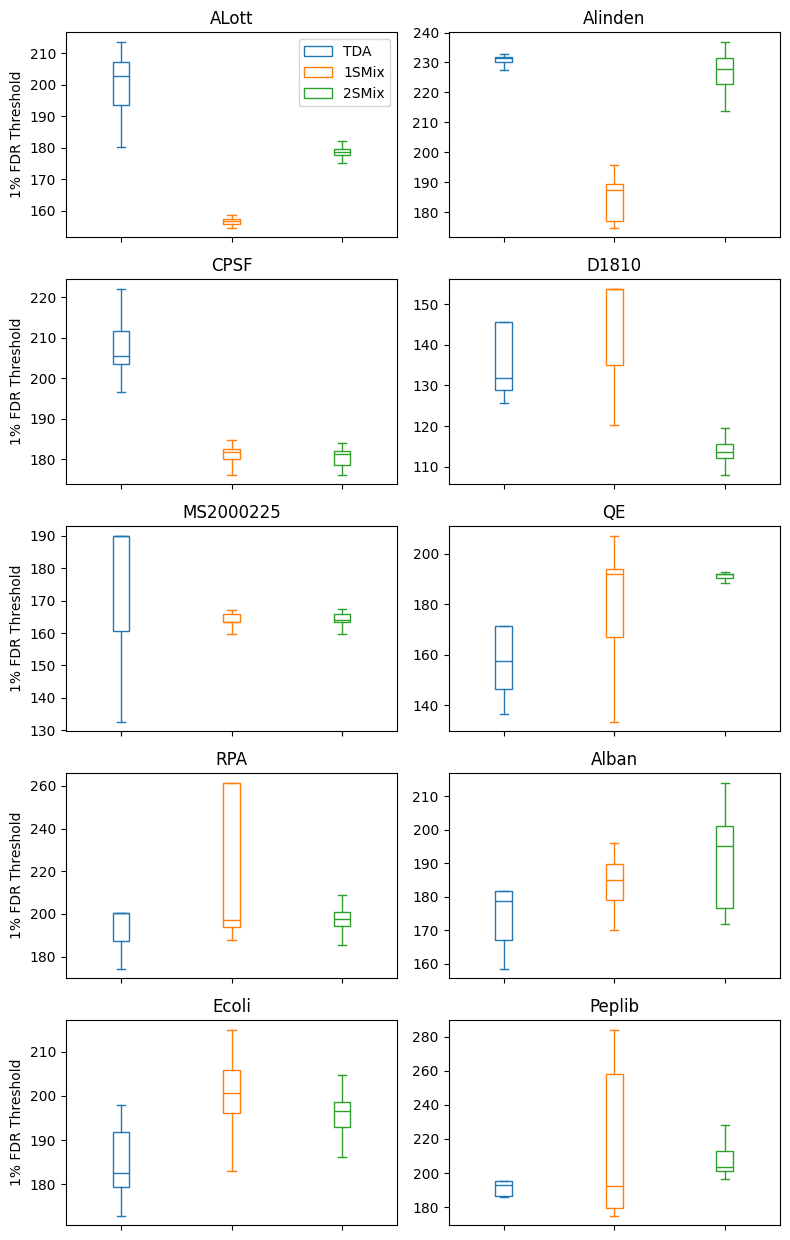

In [58]:
# for i in range(3):

fig = plt.figure(figsize=(16 / 4 * 2, 10 / 4 * 5))

for j in range(best_models.shape[1]):
    ax = plt.subplot(5, 2, j+1)
    dataset_name = skeys[1][j]
    plot_threses(dataset_name, all_thres[:, j, :].T, ax, show_legend=j==0, show_ylabel=j%2==0)
    # ax.boxplot(take_fdr_thres(take_model(bests[:, j, :].T)))
    # fig.align_labels()
fig.tight_layout()

In [59]:
fig.savefig('../bootstrap_plot_all.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [61]:
plot_datasets = [
    'ecoli_xl',
    'peplib',
    'Alinden',
    'D1810',
    'RPA',
    'CPSF',
]

2 3
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)


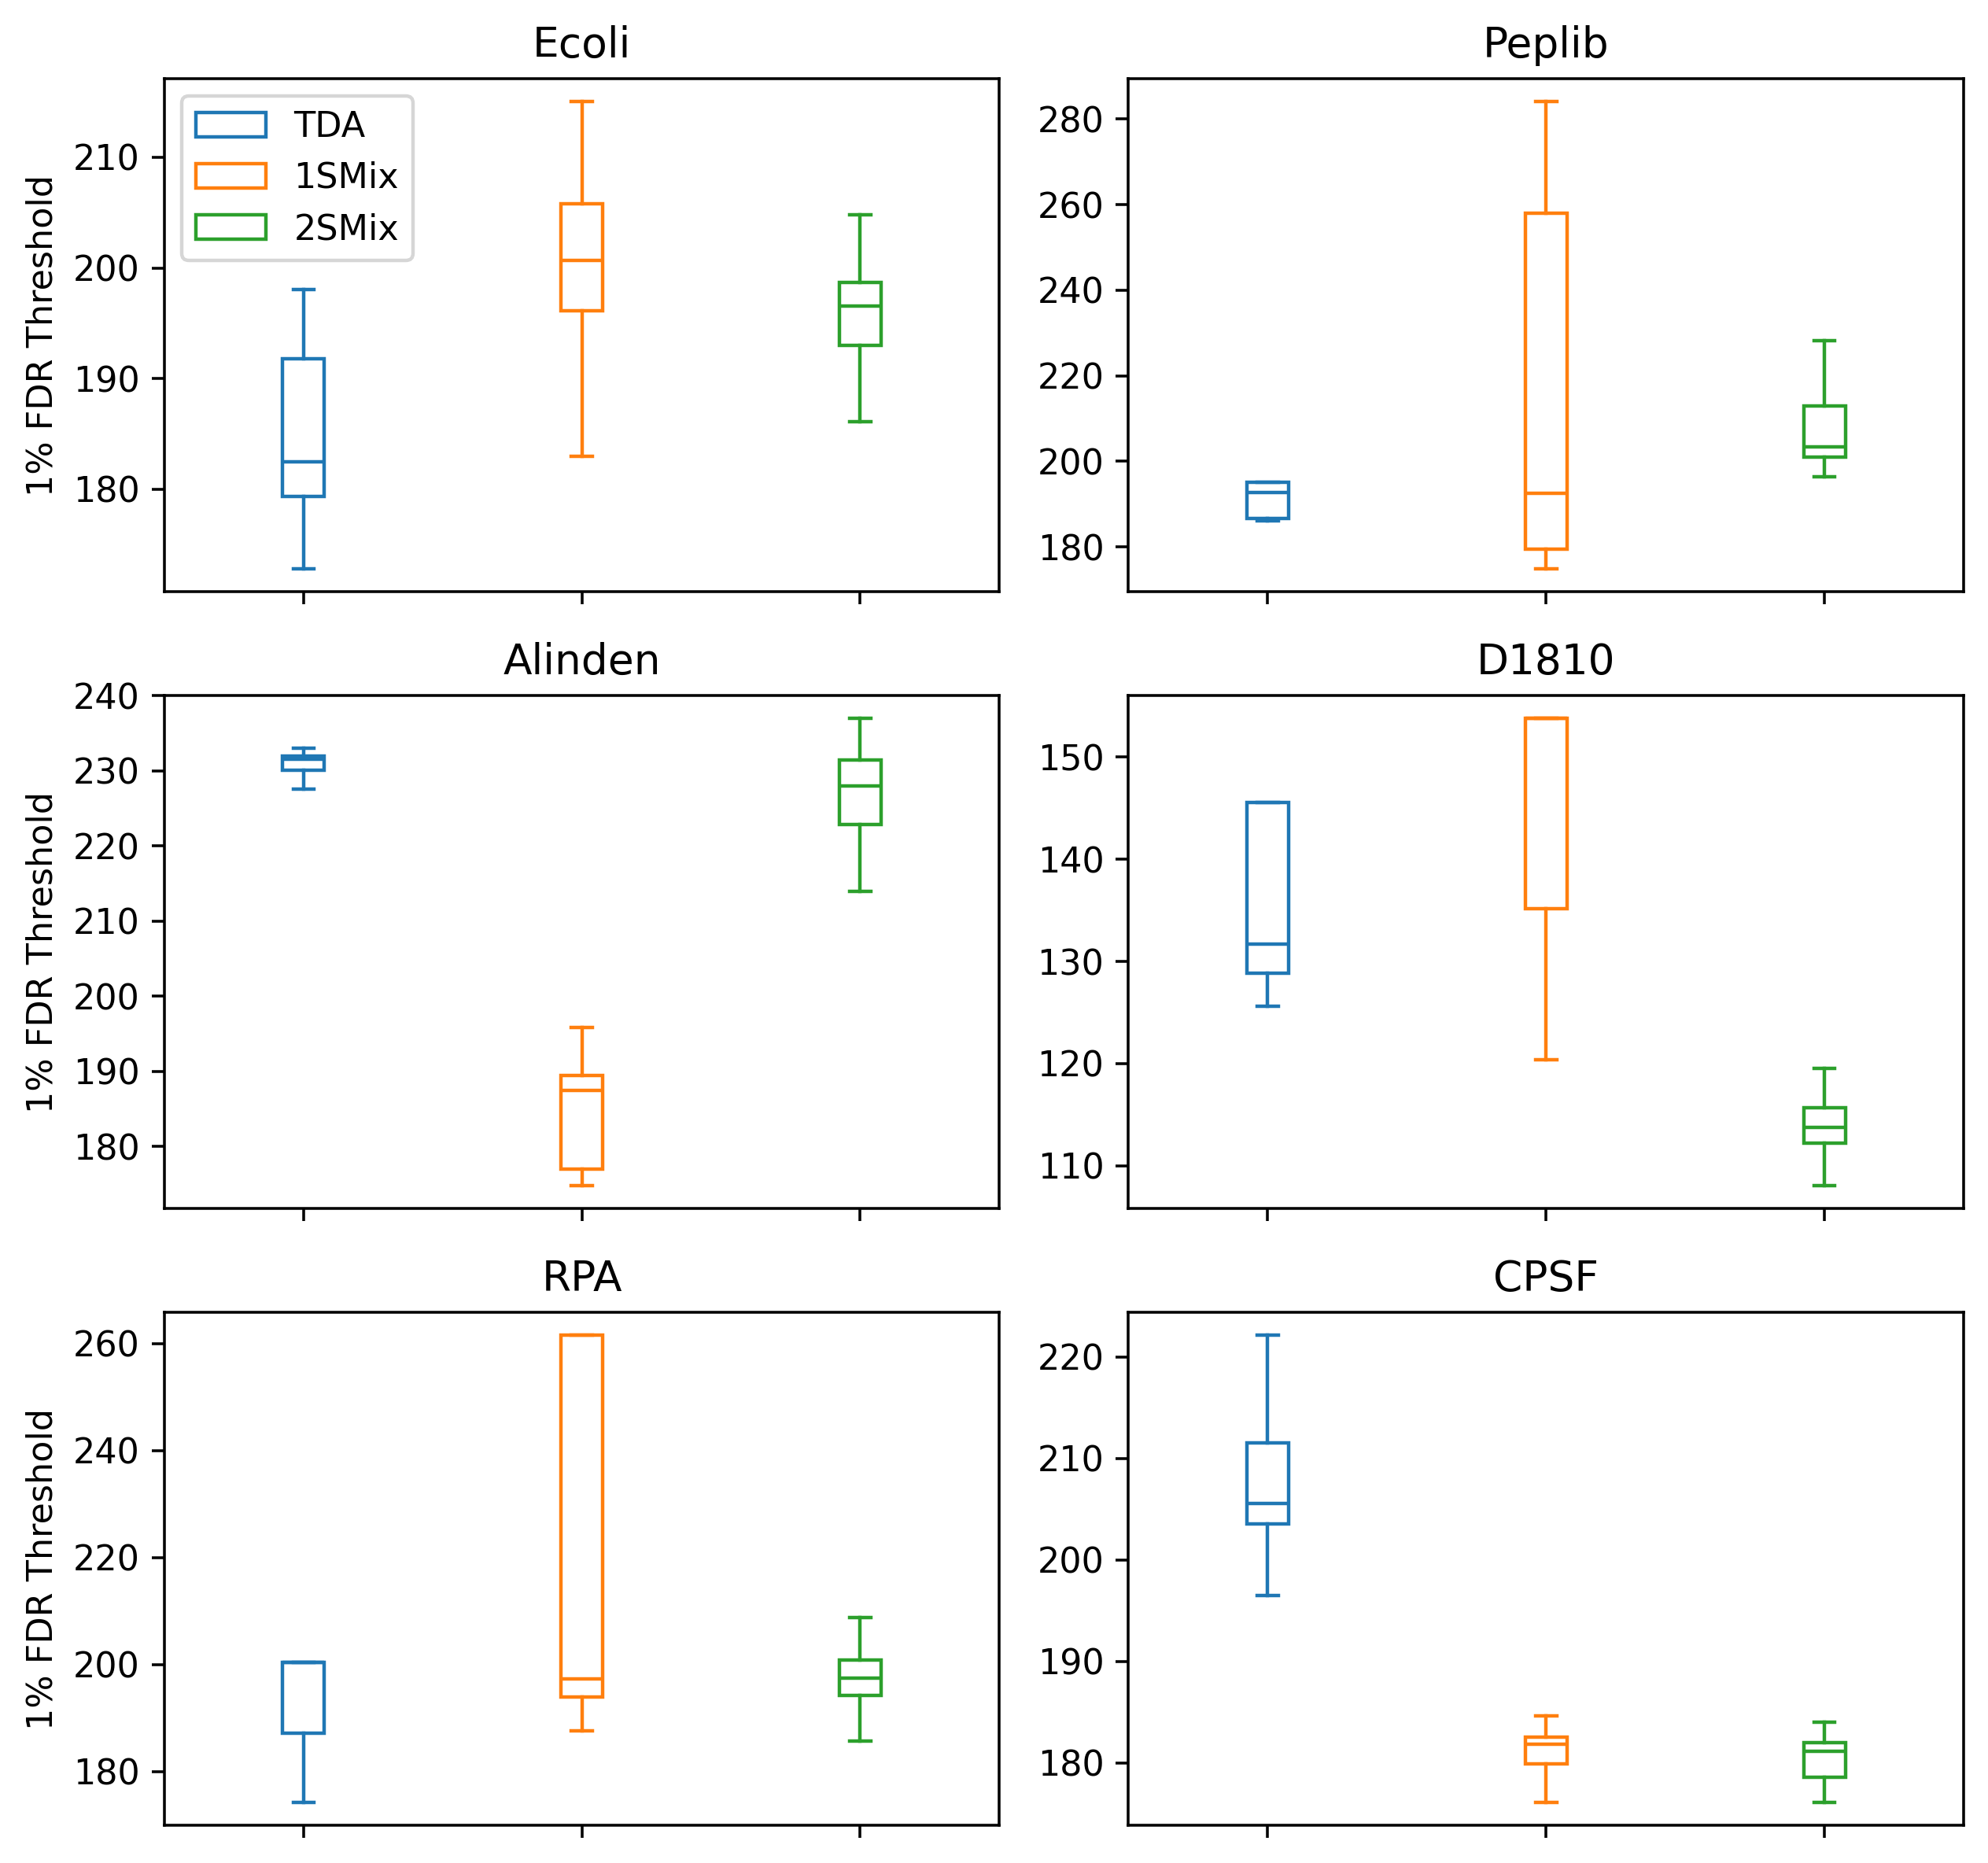

In [62]:
j = 0

dataset_ind = {dataset_name: i for i, dataset_name in enumerate(skeys[1])}

ncols = 2
nrows = (len(plot_datasets) + ncols - 1) // ncols

print(ncols, nrows)

fig = plt.figure(figsize=[16 / 4 * ncols, 10 / 4 * nrows], dpi=320)
for dataset_name in plot_datasets:
    ind = dataset_ind[dataset_name]
    ax = plt.subplot(nrows, ncols, j + 1)
    # plot_threses(dataset_name, all_thres[:, ind, :].T, ax, j >= len(plot_datasets) - 2)
    plot_threses(dataset_name, all_thres[:, ind, :].T, ax, show_legend=j==0, show_ylabel=j%ncols==0)
    j += 1

fig.tight_layout()

In [63]:
fig.savefig('../bootstrap_plot2.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
pickle.dump((skeys, res), open('../bootstrap/res.pickle', 'wb'))

In [ ]:
(skeys, res) = pickle.load(open('../bootstrap/res.pickle', 'rb'))

In [ ]:
%%sh
ls

## Plot #PSMs

### map from fdr thres to #psms

In [79]:
datasets_data = []
datasets = []
for j in range(10):
    dataset_name = skeys[1][j]
    dataset = XLMS_Dataset(dataset_name)
    datasets_data.append(dataset)
    print(dataset.mat.shape)

{'mat': array([[ 96.5485413 ,  92.97922496,  91.913342  , ..., 174.70944811,
        155.95243559,  41.12319712],
       [  0.        ,  86.91293446,  62.32423515, ..., 138.79110382,
        155.48439773,  36.44308847]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
(2, 308971)
{'mat': array([[ 94.65938595, 115.29969757,  47.48114986, ..., 132.10294541,
        144.0833605 , 173.12160491],
       [ 94.3429953 ,  99.92061167,  47.37672058, ..., 130.95151395,
        139.6517598 , 151.4703995 ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
(2, 490217)
{'mat': array([[124.99339504, 117.30916394,  99.68714052, ..., 108.79144509,
         95.82212858,  88.75812833],
       [121.54304036, 108.21935916,  98.14698048, ..., 104.61096083,
         85.48101457,  76.42711098]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_f

In [73]:
all_thres.shape

(3, 10, 50)

In [83]:
all_npsms = np.zeros_like(all_thres, dtype=int)

In [84]:
for i in range(3):
    for j in range(10):
        dataset = datasets_data[j]
        for k in range(50):
            all_npsms[i, j, k] = (dataset.mat.T[:, 0] > all_thres[i, j, k]).sum()

In [85]:
all_npsms

array([[[14609,  4665,  3187, ...,  3187,  3187,  3695],
        [ 3420,  3073,  3613, ...,  3141,  3306,  3247],
        [  276,   670,   449, ...,   747,   449,   638],
        ...,
        [  697,   697,   697, ...,  1188,   697,  1441],
        [  346,   300,   238, ...,   300,   238,   361],
        [ 7139,  2785,  3168, ...,  2941,  6014,  6180]],

       [[40613, 43368, 42452, ..., 41413, 39404, 44105],
        [27843, 39432, 20809, ..., 38486, 23570, 24478],
        [ 1456,  1476,  1390, ...,  1477,  1528,  1625],
        ...,
        [  854,   498,   454, ...,   919,   748,   769],
        [  202,   313,   141, ...,   210,   189,   245],
        [ 4147,  3100,  3989, ...,  4024,     2,  3991]],

       [[19506, 20958, 22036, ..., 19719, 17437, 18577],
        [ 4595,  5605,  4941, ...,  5292,  3503,  2918],
        [ 1625,  1390,  1640, ...,  1477,  1528,  1625],
        ...,
        [  237,   418,   393, ...,   919,   865,   886],
        [  279,   232,   208, ...,   220,   2

### Plot #psms

In [106]:
def plot_psm_over_threses(dataset_name, npsms, ax, show_tick_label=False, show_legend=False, show_ylabel=False, show_xticks=False):
    # for i in range(npsms.shape[1]):
        # ax.boxplot(npsms, notch=False, showfliers=False, boxprops={'color': })
    arts = []
    for i in range(npsms.shape[1]):
        # box_plot(ax, [i], npsms[:, i], cmap(i), cmap(i))
        arts.append(box_plot(ax, [i], npsms[:, i], cmap(i), 'white'))
    # ax.boxplot(mix_thres[:, j, :].T)
    ax.set_title(capitalize(dataset_name.replace('_xl', '')))
    print(npsms.shape)
    if not show_xticks:
        ax.set_xticklabels([''] * npsms.shape[1])
    else:
        ax.set_xticklabels(['TDA', '1SMix', '2SMix'])
    if show_legend:
        ax.legend(arts, ['TDA', '1SMix', '2SMix'])
    # if show_tick_label:
    #     ax.set_xticklabels(['TDA'] + skeys[0], rotation=45, ha='right')
    # else:
    #     ax.set_xticklabels([''] * npsms.shape[1])
    if show_ylabel:
        ax.set_ylabel('#PSM below 1% FDR')


In [108]:
plot_datasets = ['ALott', 'D1810', 'CPSF', 'ecoli_xl',]

4 1
(50, 3)
(50, 3)
(50, 3)
(50, 3)


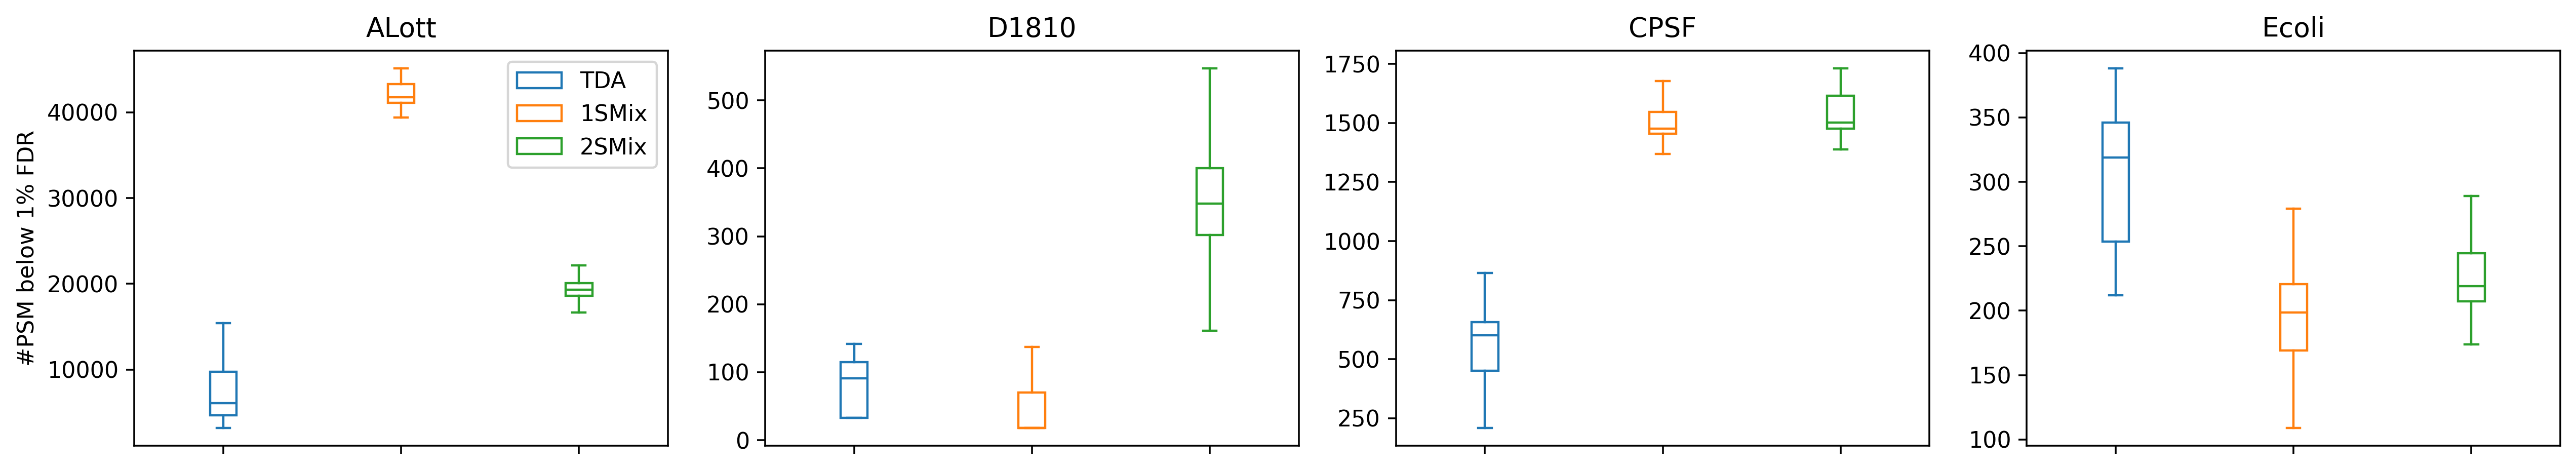

In [109]:
j = 0

dataset_ind = {dataset_name: i for i, dataset_name in enumerate(skeys[1])}

ncols = 4
nrows = (len(plot_datasets) + ncols - 1) // ncols

print(ncols, nrows)

fig = plt.figure(figsize=[4 * ncols, 3 * nrows], dpi=320)
for dataset_name in plot_datasets:
    ind = dataset_ind[dataset_name]
    ax = plt.subplot(nrows, ncols, j + 1)
    # plot_threses(dataset_name, all_thres[:, ind, :].T, ax, j >= len(plot_datasets) - 2)
    plot_psm_over_threses(dataset_name, all_npsms[:, ind, :].T, ax, show_legend=j==0, show_ylabel=j==0)
    j += 1

fig.tight_layout()

In [97]:
fig.savefig('../bootstrap_psm_plot.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)


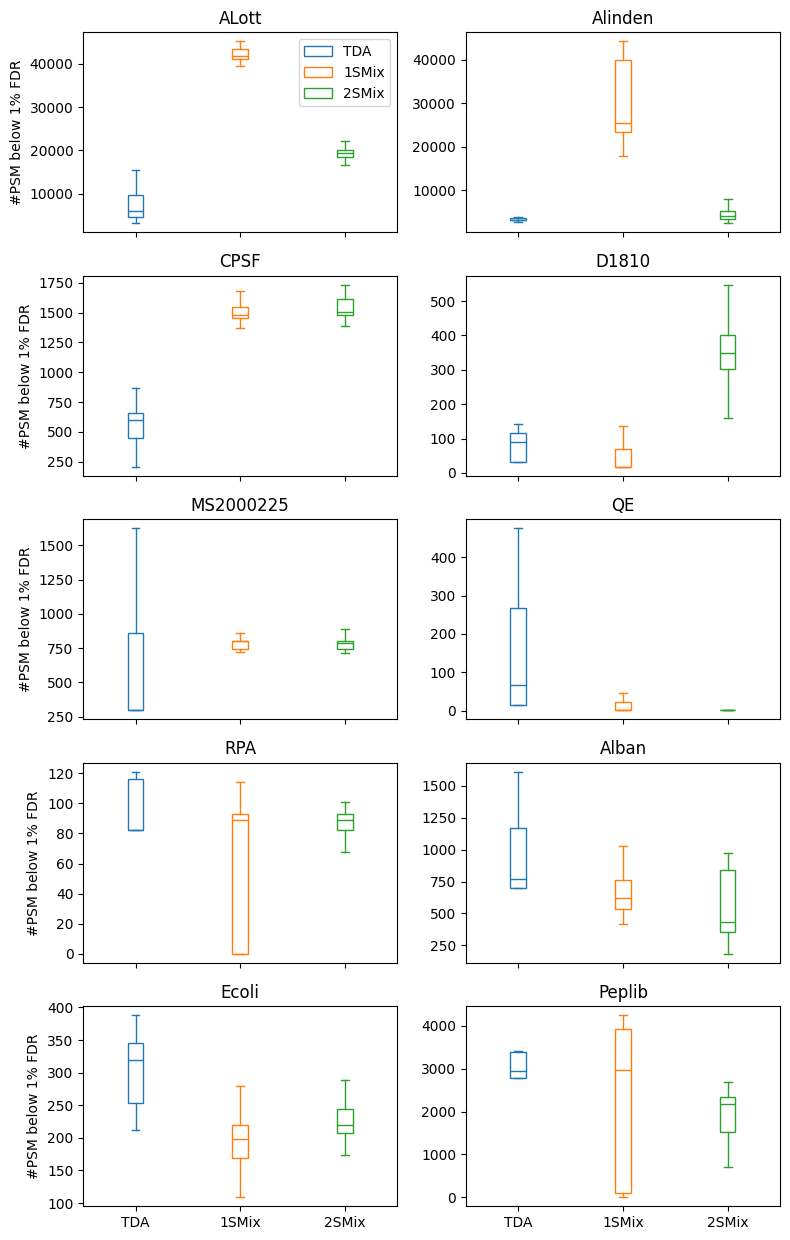

In [111]:
# for i in range(3):

fig = plt.figure(figsize=(16 / 4 * 2, 10 / 4 * 5))

for j in range(best_models.shape[1]):
    ax = plt.subplot(5, 2, j+1)
    dataset_name = skeys[1][j]
    plot_psm_over_threses(dataset_name, all_npsms[:, j, :].T, ax, show_legend=j==0, show_ylabel=j%2==0, show_xticks=j>=8)
    # ax.boxplot(take_fdr_thres(take_model(bests[:, j, :].T)))
    # fig.align_labels()
fig.tight_layout()

In [112]:
fig.savefig('../bootstrap_psm_plot_all.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [113]:
plot_datasets = [
    'ecoli_xl',
    'peplib',
    'Alinden',
    'D1810',
    'RPA',
    'CPSF',
]

2 3
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)
(50, 3)


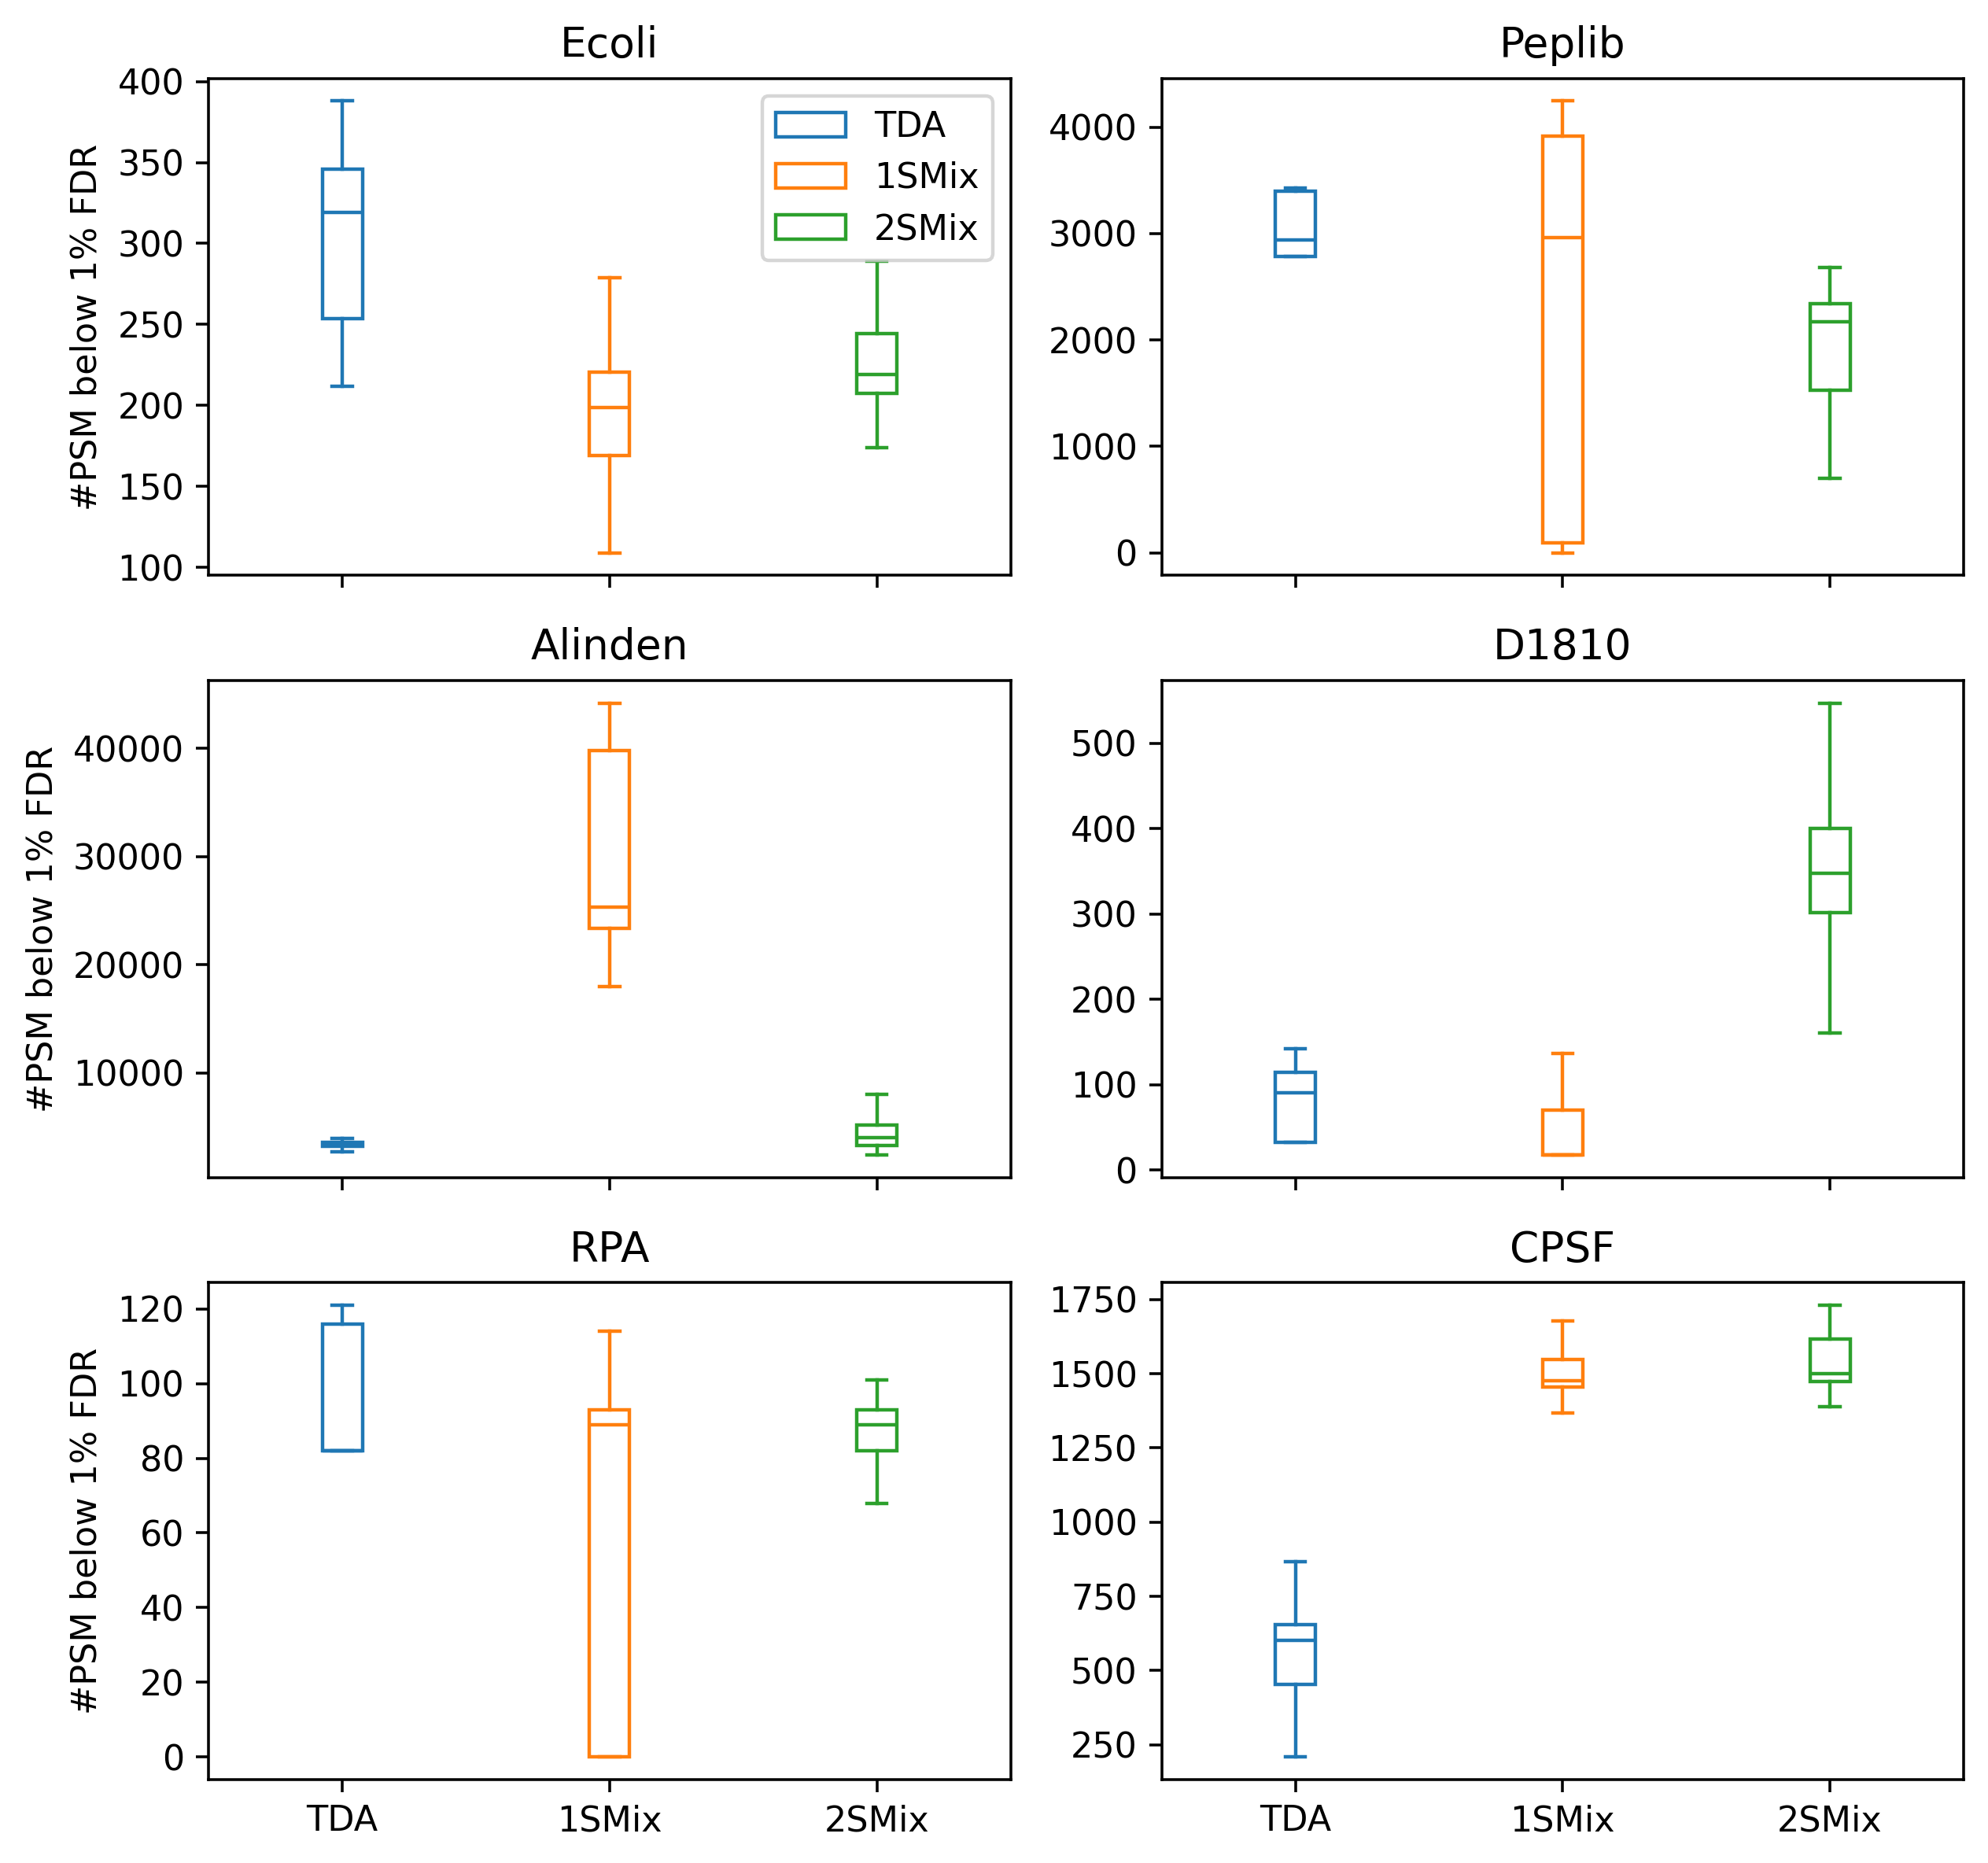

In [114]:
j = 0

dataset_ind = {dataset_name: i for i, dataset_name in enumerate(skeys[1])}

ncols = 2
nrows = (len(plot_datasets) + ncols - 1) // ncols

print(ncols, nrows)

fig = plt.figure(figsize=[16 / 4 * ncols, 10 / 4 * nrows], dpi=320)
for dataset_name in plot_datasets:
    ind = dataset_ind[dataset_name]
    ax = plt.subplot(nrows, ncols, j + 1)
    # plot_threses(dataset_name, all_thres[:, ind, :].T, ax, j >= len(plot_datasets) - 2)
    plot_psm_over_threses(dataset_name, all_npsms[:, ind, :].T, ax, show_legend=j==0, show_ylabel=j%ncols==0, show_xticks=j>=4)
    j += 1

fig.tight_layout()

In [115]:
fig.savefig('../bootstrap_psm_plot.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
